In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import keras
from keras_rnadam import RNAdam
import pylab as pl

C:\Users\IYI\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:


def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))




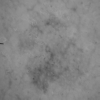

In [3]:
Image.open("dataset/1/s (1).pgm")

In [4]:
img = read_image('dataset/1/s (1).pgm')

In [5]:
img.shape

(100, 100)

In [6]:
size = 2
total_sample_size = 15000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('dataset/' +str(1)+ '/' + 's ('+str(1) + ')'+'.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(9):
        for j in range(int(total_sample_size/9)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(80)
                ind2 = np.random.randint(80)
            
            # read the two images
            img1 = read_image('dataset/' + str(i+1) + '/' +  's ('+ str(ind1 + 1) + ')'+'.pgm', 'rw+')
            img2 = read_image('dataset/' + str(i+1) + '/' +'s ('+ str(ind2 + 1) + ')'+ '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/80)):
        for j in range(80):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(9)
                ind2 = np.random.randint(9)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('dataset/' + str(ind1+1) + '/' +   's ('+ str(j + 1) + ')'+'.pgm', 'rw+')
            img2 = read_image('dataset/' + str(ind2+1) + '/' +  's ('+ str(j + 1) + ')'+ '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [7]:
X, Y = get_data(size, total_sample_size)

In [8]:
X.shape

(20000, 2, 1, 50, 50)

In [9]:
Y.shape

(20000, 1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [11]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [12]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [13]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

C:\Users\IYI\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 50, 50..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\IYI\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
C:\Users\IYI\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [16]:
epochs = 60
rms = RNAdam()

In [17]:
model = Model(input=[img_a, img_b], output=distance)

C:\Users\IYI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


In [18]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [19]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
  
# Modelimizin eğitim ve test verisi üzerinde nasıl çalıştığını görebilmek için.
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
model.compile(loss= contrastive_loss,optimizer=rms,metrics=[accuracy])

In [20]:
img1 = x_train[:, 0]
img2 = x_train[:, 1]

In [21]:
history=model.fit([img1, img2], y_train, validation_split=.25,batch_size=128, verbose=2,nb_epoch=epochs)

C:\Users\IYI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 11250 samples, validate on 3750 samples
Epoch 1/60
 - 90s - loss: 0.2610 - accuracy: 0.4979 - val_loss: 0.4331 - val_accuracy: 0.5051
Epoch 2/60
 - 87s - loss: 0.2614 - accuracy: 0.5014 - val_loss: 0.4455 - val_accuracy: 0.5051
Epoch 3/60
 - 85s - loss: 0.2602 - accuracy: 0.5114 - val_loss: 0.4369 - val_accuracy: 0.5051
Epoch 4/60
 - 87s - loss: 0.2569 - accuracy: 0.5209 - val_loss: 0.4227 - val_accuracy: 0.5051
Epoch 5/60
 - 89s - loss: 0.2539 - accuracy: 0.5358 - val_loss: 0.4073 - val_accuracy: 0.5051
Epoch 6/60
 - 87s - loss: 0.2529 - accuracy: 0.5411 - val_loss: 0.3939 - val_accuracy: 0.5051
Epoch 7/60
 - 90s - loss: 0.2493 - accuracy: 0.5501 - val_loss: 0.3821 - val_accuracy: 0.5051
Epoch 8/60
 - 89s - loss: 0.2462 - accuracy: 0.5585 - val_loss: 0.3666 - val_accuracy: 0.5072
Epoch 9/60
 - 83s - loss: 0.2440 - accuracy: 0.5707 - val_loss: 0.3512 - val_accuracy: 0.5115
Epoch 10/60
 - 83s - loss: 0.2406 - accuracy: 0.5728 - val_loss: 0.3375 - val_accuracy: 0.5288
Epoch 11/6

In [22]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [23]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

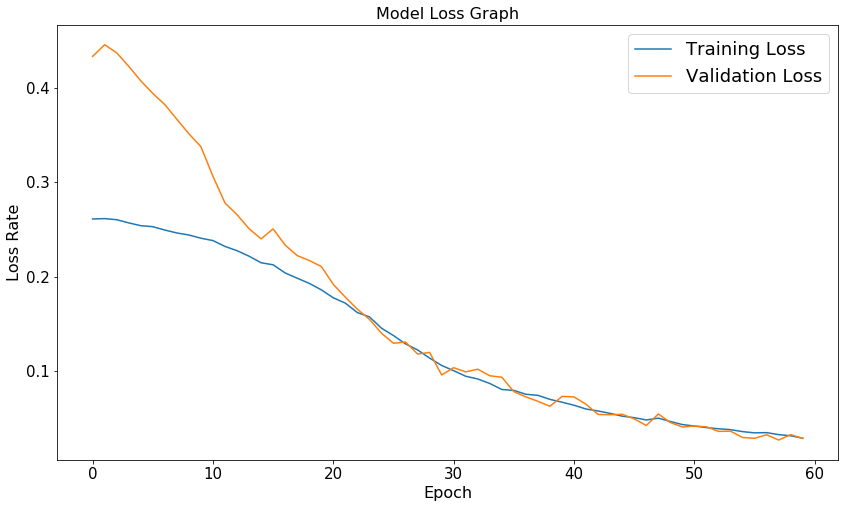

In [25]:
# Plot training & validation accuracy values
fig = plt.gcf()
fig.set_size_inches(14,8, forward = False)
plt.rc('legend',**{'fontsize':18})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Graph',fontsize=16)
plt.ylabel('Loss Rate',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

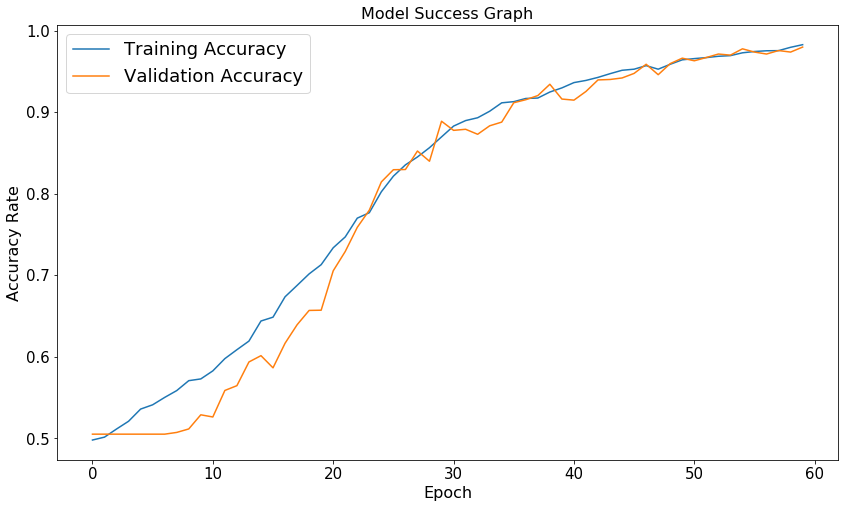

In [26]:
fig = plt.gcf()
fig.set_size_inches(14,8, forward = False)
plt.rc('legend',**{'fontsize':18})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Success Graph',fontsize=16)
plt.ylabel('Accuracy Rate',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()
model.save("model_RNAdam.h5")

In [27]:
from PIL import Image
from skimage.transform import resize
import glob
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import keras.backend as K
import keras
from keras_rnadam import RNAdam
%matplotlib inline

In [28]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
  
# Modelimizin eğitim ve test verisi üzerinde nasıl çalıştığını görebilmek için.
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [29]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
#model = keras.models.load_model("model_RNAdam.h5", custom_objects={'RNAdam': RNAdam}) 
data_dir = "dataset" # Veri seti klasörü
size     = 2


In [30]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}'.format(accuracy))
    plt.savefig("confusion_matrix.png", dpi=150)
    plt.show()

In [138]:
images_path = glob.glob(f"{data_dir}/*/*.pgm") # tüm resimlerin yolu (path)
images_path = list(np.random.choice(images_path, 20)) # rastgele 20 tane resim seç (eğer bu kod satırını "yorum satırına" çevirirseniz kodun çalışması biraz uzun sürecektir)
images_path[:5]

['dataset\\1\\s (37).pgm',
 'dataset\\6\\s (75).pgm',
 'dataset\\1\\s (79).pgm',
 'dataset\\7\\s (50).pgm',
 'dataset\\3\\s (36).pgm']

In [31]:
model = load_model("model_RNAdam.h5", custom_objects={"contrastive_loss":contrastive_loss ,"RNAdam": RNAdam})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 50, 50)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 50, 50)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           395582      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          